In [5]:
from IPython import get_ipython
get_ipython().magic('reset -sf')

import warnings
warnings.filterwarnings('ignore')

In [6]:
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
#from sklearn.grid_search import GridSearchCV   #Perforing grid search
from imblearn.over_sampling import SMOTE       #over sampling of minority class in imbalanced data
from imblearn.combine import SMOTEENN          #over sampling of minority class in imbalanced data
from sklearn.model_selection import train_test_split, cross_validate, StratifiedKFold,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_recall_fscore_support

from sklearn.feature_selection import RFE,RFECV
from sklearn.linear_model import LogisticRegression,LogisticRegressionCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score,average_precision_score,precision_recall_curve,precision_score

import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline

pd.set_option('display.max_columns', 50)
pd.set_option('display.max_columns', 100)

In [7]:
# read the input files and look at the top few lines #
data_path = "/Users/venkatasravankanukolanu/Documents/Data Files/credit_fraud/"
data_df= pd.read_csv(data_path+"creditcard.csv")
data_df.head(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0


Since all the features except Time and Amount are Principal Components, we will standardize Time and Amount.

In [8]:
data_df['std_amount'] = StandardScaler().fit_transform(data_df['Amount'].reshape(-1, 1))
data_df= data_df.drop(['Time','Amount'],axis=1)
data_df.head(2)

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475


Since V1 through V28 are principal compotents from PCA on the actual data, V1 through V28 are independent. This eliminates the problem of multicolinearity in the data. 

Since the data set meets the assumptions of Binary Logistic Regression Model i.e.

1. The dependent variable is binary.
2. The factor level 1 of the dependent variable represents the desired outcome i.e. fraud.
3. The independent variables are independent of each other since they are principal components.

In [9]:
response='Class'
pred=data_df.columns[data_df.columns != 'Class']

#### Split the data as test and train

In [10]:
df_train, df_test = train_test_split(data_df, test_size=0.1, random_state=2,stratify=data_df[response])

### Variable Importance using RFE and Cross Validation

We will find the optimal number of features to use in a Logistic Regression model and the list of features by using recursive feature elimination method along with 5-fold cross validation. 

In [11]:
# Create the RFE object and compute a cross-validated score.
# Scoring is based on Recall
def rfe_cv(x_train_data,y_train_data):
    rfecv = RFECV(estimator=LogisticRegression(), step=1, cv=5, scoring='recall')
    rfecv.fit(x_train_data, y_train_data)
    
    selected_features=list(x_train_data.columns[rfecv.support_])
    
    print("Optimal number of features: %d" % rfecv.n_features_)
    print('Selected features: %s' % selected_features)

    # Plot number of features VS. cross-validation scores
    plt.figure(figsize=(10,6))
    plt.xlabel("Number of features selected")
    plt.ylabel("Cross validation score (Recall)")
    plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
    plt.show()
    
    return(selected_features)

Optimal number of features: 25
Selected features: ['V1', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V12', 'V13', 'V14', 'V15', 'V16', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'std_amount']


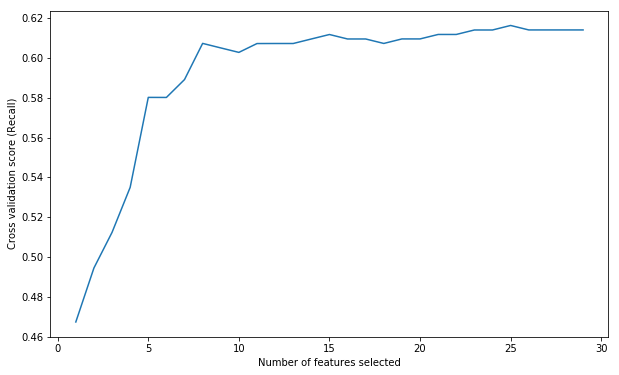

In [13]:
predictors=rfe_cv(df_train[pred], df_train[response])

### Logistic Regression and Cross Validation

We will training a logistic regression and test it on a validation set. For this we will define 2 functions:
1. To train a Logit model and test it on a validation set
2. To evaluate the Logit model using Stratified K-fold cross-validation

In [14]:
##Function for training models and testing on a test set. if plot is True, it plots a PRC curve for 
##training and test sets and finds the threshold where (precision*recall) is maximum.
def logreg_fit(alg,dtrain,dtest,predictors,response,plot=True):
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain[response])
        
    #Predict training set:
    dtrain_pred = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
    
    dtest_pred = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]
    
    prf_train=precision_recall_fscore_support(dtrain[response], dtrain_pred,pos_label =1, average ='binary')
    prf_test=precision_recall_fscore_support(dtest[response], dtest_pred,pos_label =1, average ='binary')
    area_prc_test=average_precision_score(dtest[response], dtest_predprob,average=None)
    area_prc_train=average_precision_score(dtrain[response], dtrain_predprob,average=None)
    
    
    precision_train, recall_train, thr_train = precision_recall_curve(dtrain[response], dtrain_predprob,pos_label =1)
    precision_test, recall_test, thr_test = precision_recall_curve(dtest[response],dtest_predprob,pos_label =1)
    
    #area, thr = ((precision_test)*(recall_test)), thr_test
    #idx= np.argmax(area)
    
    
    print "Model report on training data:"
    print "Train: Precision: %.4g" % (prf_train[0]*100)
    print "Train: Recall : %.4g" % (prf_train[1]*100)
    print "Average Precision (Train): %f" % (area_prc_train*100)
    print "\nModel report on test data:"
    print "Test: Precision: %.4g" % (prf_test[0]*100)
    print "Test: Recall : %.4g" % (prf_test[1]*100)
    print "Average Precision (Trest): %f" % (area_prc_test*100)

    if plot:
        plt.figure(figsize=(10,6))
        plt.plot(recall_test, precision_test, color='coral',label=' Test PR-Curve')
        plt.plot(recall_train, precision_train, color='green',label=' Train PR-Curve')
        plt.plot([0, 1], [0, 1], 'k--')
        #plt.plot([0,recall_test[idx]], [precision_test[idx],precision_test[idx]], 'k--', color='blue')
        #plt.plot([recall_test[idx],recall_test[idx]], [0,precision_test[idx]], 'k--', color='blue')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.show()

In [15]:
#Function for K-Fold Stratified Cross_validation of any model
def cv_modelfit(alg,dtrain,predictors,response,cvfolds):

    skf = StratifiedKFold(n_splits=cvfolds,random_state=2)
    cv_results = np.zeros((cvfolds, 3))
    for i, (train_index, test_index) in enumerate(skf.split(dtrain[predictors],dtrain[response])):
        for j in range(0,3):
            cvtrain=dtrain.iloc[train_index]
            cvtest=dtrain.iloc[test_index]

            #Fit the algorithm on the data
            alg.fit(cvtrain[predictors], cvtrain[response])

            #Predict training set:
            dtrain_pred = alg.predict(cvtrain[predictors])
            dtrain_predprob = alg.predict_proba(cvtrain[predictors])[:,1]

            dtest_pred = alg.predict(cvtest[predictors])
            dtest_predprob = alg.predict_proba(cvtest[predictors])[:,1]

            prf_train=precision_recall_fscore_support(cvtrain[response], dtrain_pred,pos_label =1, average ='binary')
            prf_test=precision_recall_fscore_support(cvtest[response], dtest_pred,pos_label =1, average ='binary')
            area_prc_test=average_precision_score(cvtest[response], dtest_predprob,average=None)
            area_prc_train=average_precision_score(cvtrain[response], dtrain_predprob,average=None)


            cvr=[prf_test[0],prf_test[1],area_prc_test]
            cv_results[i,j]=cvr[j]

    print "Mean CV Test Precision: %.4g" % (cv_results[:,0].mean()*100)
    print "Mean CV Test Recall: %.4g" % (cv_results[:,1].mean()*100)
    print "Std.Devation of CV Test Precision: %.4g" % (cv_results[:,0].std()*100)
    print "Std.Devation of CV Test Recall: %.4g" % (cv_results[:,1].std()*100)

Split the training data set into training and validation data sets.

In [16]:
train, test = train_test_split(df_train,test_size=0.1, random_state=2,stratify=df_train[response])

#### Baseline Logistic Regression Model

In [17]:
logreg1 = LogisticRegression(penalty = 'l1', C=1,random_state = 2)

Model report on training data:
Train: Precision: 87.5
Train: Recall : 63.16
Average Precision (Train): 76.728565

Model report on test data:
Test: Precision: 91.3
Test: Recall : 47.73
Average Precision (Trest): 69.393804


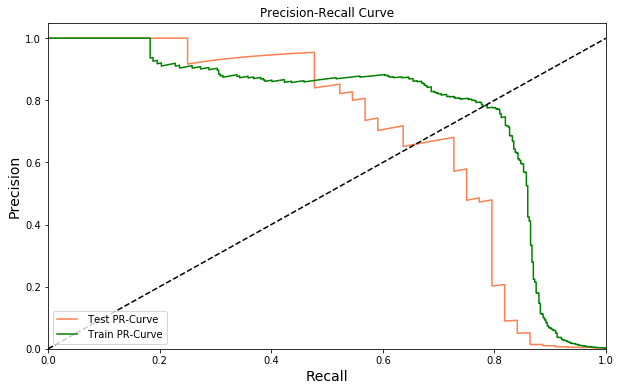

In [18]:
logreg_fit(logreg1,train,test,predictors,response,True)

The baseline logistic regression model gave a Recall of 47.7% and Precision of 91.3% on a validation set. We actually need a model with higher recall value to be able to predict the fraud transactions accurately. Since the results from a validation set approach could have high variability, we will use 10-fold cross validation to evalidate the model accurately.

### Model evaluation with 10-Fold Cross Validation

We will use 10-fold cross validation to accurately evaluate the model scores.

In [19]:
cv_modelfit(logreg1,df_train,predictors,response,10)

Mean CV Test Precision: 87.55
Mean CV Test Recall: 62.32
Std.Devation of CV Test Precision: 4.782
Std.Devation of CV Test Recall: 8.233


Mean test recall from 10-fold cross validation is 62.3% and precision is 87.5%. This means the model accurately predicts fraud transactions as fraud 62.3% of the time and 87.5% of the predicted fraud transactions are actually fraud. <br>
But we need a model that has high recall value as the cost of misclassifying fraud is higher for credit card companies. So we will try to balance the data by over-sampling the positive class using synthetic over-sampling methid SMOTE.

### Balancing by over-sampling minority class using SMOTE

We will start by balancing the data set using SMOTE technique. First we will balance the data set by SMOTE and then apply logistic regression model on the balanced data set. <br>
SMOTE technique should be applied only on the training data, after splitting the data set into training set and validation set. If we apply SMOTE before splitting the data, we would leak the information in validation set into the training set. We will define a function to balance the data and train a model.

In [20]:
##Function for training models and testing on a test set. if plot is True, it plots a PRC curve for 
##training and test sets and finds the threshold where (precision*recall) is maximum.
def logreg_smote(alg,sam_alg,data,predictors,response,plot=True):

    dtrain, dtest = train_test_split(data, test_size=0.1, random_state=2,stratify=data[response])

    
    X_smt, y_smt=sam_alg.fit_sample(train[predictors],train[response])
    X_smt=pd.DataFrame(X_smt)
    columns=train[predictors].columns
    X_smt.columns=columns

    #Fit the algorithm on the data
    alg.fit(X_smt[predictors], y_smt)

    #Predict training set:
    dtrain_pred = alg.predict(X_smt[predictors])
    dtrain_predprob = alg.predict_proba(X_smt[predictors])[:,1]

    #a=float(len(data[data[response]==1]))/float(len(data[response]))
    #b=float(len(y_smt[y_smt==1]))/float(len(y_smt))
    #k=(b/(1-b))*((1-a)/a)

    dtest_pred = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]#/k  

    prf_train=precision_recall_fscore_support(y_smt, dtrain_pred,pos_label =1, average ='binary')
    prf_test=precision_recall_fscore_support(dtest[response], dtest_pred,pos_label =1, average ='binary')
    area_prc_test=average_precision_score(dtest[response], dtest_predprob,average=None)
    area_prc_train=average_precision_score(y_smt, dtrain_predprob,average=None)


    precision_train, recall_train, thr_train = precision_recall_curve(y_smt, dtrain_predprob,pos_label =1)
    precision_test, recall_test, thr_test = precision_recall_curve(dtest[response],dtest_predprob,pos_label =1)

    #area, thr = ((precision_test)*(recall_test)), thr_test
    #idx= np.argmax(area)
    
    print "Model report on training data:"
    print "Train: Precision: %.4g" % (prf_train[0]*100)
    print "Train: Recall : %.4g" % (prf_train[1]*100)
    print "Average Precision (Train): %f" % (area_prc_train*100)
    print "\nModel report on test data:"
    print "Test: Precision: %.4g" % (prf_test[0]*100)
    print "Test: Recall : %.4g" % (prf_test[1]*100)
    print "Average Precision (Trest): %f" % (area_prc_test*100)

    
    if plot:

        plt.figure(figsize=(10,6))
        plt.plot(recall_test, precision_test, color='coral',label=' Test PR-Curve')
        plt.plot(recall_train, precision_train, color='green',label=' Train PR-Curve')
        plt.plot([0, 1], [0, 1], 'k--')
        #plt.plot([0,recall_test[idx]], [precision_test[idx],precision_test[idx]], 'k--', color='blue')
        #plt.plot([recall_test[idx],recall_test[idx]], [0,precision_test[idx]], 'k--', color='blue')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall', fontsize=14)
        plt.ylabel('Precision', fontsize=14)
        plt.title('Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.show()

We will over-sample the positive class to an equivalent number as the negative class using SMOTE and use the balanced training data to train a logit model. But we will test the model on a unbalanced validation set.

In [21]:
sampling1=SMOTE(ratio=1.0, random_state=2, k=None, k_neighbors=5, 
          m=None, m_neighbors=10, out_step=0.5, kind='regular', svm_estimator=None, n_jobs=-1)

Model report on training data:
Train: Precision: 97.04
Train: Recall : 91.97
Average Precision (Train): 98.988621

Model report on test data:
Test: Precision: 4.961
Test: Recall : 86.36
Average Precision (Trest): 65.054796


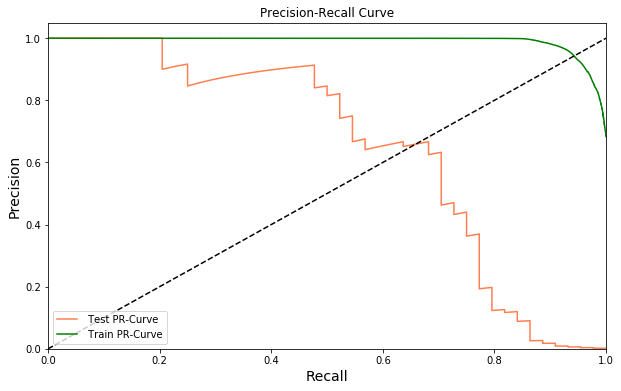

In [22]:
logreg_smote(logreg1,sampling1,df_train,predictors,response,plot=True)

Over-sampling the minority class improved the recall from 62.3% to 86.3% but the precision decreased from 87.5% to 4.9%. We will try to find the optimal ratio for over-sampling the minority class so that we get decent balance between recall and precision. <br>
We will define a function that trains a model on the balanced data with a given ratio of minority over-sampling and gives the test precision and recall on a validation set.

In [23]:
def smote_eval(alg,data,predictors,response,r):

    dtrain, dtest = train_test_split(data, test_size=0.1, random_state=2,stratify=data[response])

    smt=SMOTE(ratio=r, random_state=2, k=None, k_neighbors=5, 
          m=None, m_neighbors=10, out_step=0.5, kind='regular', svm_estimator=None, n_jobs=2)
    X_smt, y_smt=smt.fit_sample(train[predictors],train[response])
    X_smt=pd.DataFrame(X_smt)
    columns=train[predictors].columns
    X_smt.columns=columns

    #Fit the algorithm on the data
    alg.fit(X_smt[predictors], y_smt)
            
    dtest_pred = alg.predict(dtest[predictors])
    dtest_predprob = alg.predict_proba(dtest[predictors])[:,1]#/k  

    prf_test=precision_recall_fscore_support(dtest[response], dtest_pred,pos_label =1, average ='binary')
    #area_prc_test=average_precision_score(dtest[response], dtest_predprob,average=None)  
    return(prf_test[0],prf_test[1])

In [24]:
smt_ratio = np.zeros((10, 3))
for i in range(0,10,1):
    for j in range(0,3,1):
        temp=np.append(smote_eval(logreg1,df_train,predictors,response,float(i+1)/float(10)),float(i+1)/float(10))
        smt_ratio[i,j]=temp[j]

In [25]:
smt_ratio=pd.DataFrame(smt_ratio)
smt_ratio.columns=['Precision','Recall','Ratio']
smt_ratio

,Precision,Recall,Ratio
0,0.421687,0.795455,0.1
1,0.218750,0.795455,0.2
2,0.152174,0.795455,0.3
3,0.120000,0.818182,0.4
4,0.103064,0.840909,0.5
5,0.084821,0.863636,0.6
6,0.071161,0.863636,0.7
7,0.063123,0.863636,0.8
8,0.055233,0.863636,0.9
9,0.049608,0.863636,1.0


Though higher recall value is important for us but we want to get a decent balance between precision and recall as well in solving this problem. <br>
**Note: Depending on what the business goal is, we can adjust this parameter but an important point to keep in mind is that improvement in recall comes at the cost of precision.**

In [26]:
sampling2=SMOTE(ratio=0.1, random_state=2, k=None, k_neighbors=5, 
          m=None, m_neighbors=10, out_step=0.5, kind='regular', svm_estimator=None, n_jobs=-1)

Model report on training data:
Train: Precision: 98.08
Train: Recall : 86.31
Average Precision (Train): 94.874914

Model report on test data:
Test: Precision: 42.17
Test: Recall : 79.55
Average Precision (Trest): 70.917751


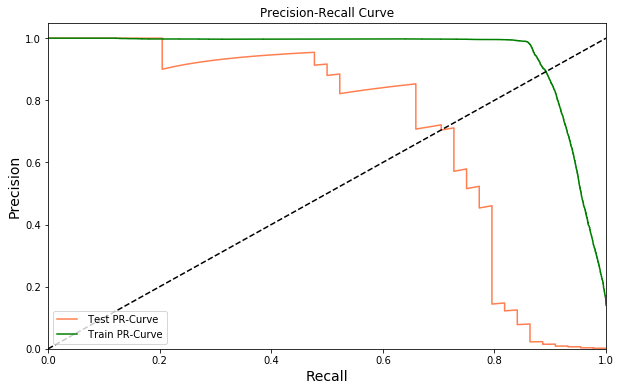

In [27]:
logreg_smote(logreg1,sampling2,df_train,predictors,response,plot=True)

### Model Evaluation using 10-fold Cross Validation

In [28]:
#Function for K-Fold Stratified Cross_validation of any model
def cv_smotemodel(alg,sam_alg,dtrain,predictors,response,cvfolds):

    skf = StratifiedKFold(n_splits=cvfolds,random_state=2)
    cv_results = np.zeros((cvfolds, 3))
    for i, (train_index, test_index) in enumerate(skf.split(dtrain[predictors],dtrain[response])):
        for j in range(0,3):
            cvtrain=dtrain.iloc[train_index]
            cvtest=dtrain.iloc[test_index]
            
            X_smt, y_smt=sam_alg.fit_sample(cvtrain[predictors], cvtrain[response])
            X_smt=pd.DataFrame(X_smt)
            columns=train[predictors].columns
            X_smt.columns=columns
            

            #Fit the algorithm on the data
            alg.fit(X_smt[predictors], y_smt)

            #Predict training set:
            dtrain_pred = alg.predict(X_smt[predictors])
            dtrain_predprob = alg.predict_proba(X_smt[predictors])[:,1]

            dtest_pred = alg.predict(cvtest[predictors])
            dtest_predprob = alg.predict_proba(cvtest[predictors])[:,1]

            prf_train=precision_recall_fscore_support(y_smt, dtrain_pred,pos_label =1, average ='binary')
            prf_test=precision_recall_fscore_support(cvtest[response], dtest_pred,pos_label =1, average ='binary')
            area_prc_test=average_precision_score(cvtest[response], dtest_predprob,average=None)
            area_prc_train=average_precision_score(y_smt, dtrain_predprob,average=None)


            cvr=[prf_test[0],prf_test[1],area_prc_test]
            cv_results[i,j]=cvr[j]

    print "Mean CV Test Precision: %.4g" % (cv_results[:,0].mean()*100)
    print "Mean CV Test Recall: %.4g" % (cv_results[:,1].mean()*100)
    print "Std.Devation of CV Test Precision: %.4g" % (cv_results[:,0].std()*100)
    print "Std.Devation of CV Test Recall: %.4g" % (cv_results[:,1].std()*100)

In [29]:
cv_smotemodel(logreg1,sampling2,df_train,predictors,response,10)

Mean CV Test Precision: 43.47
Mean CV Test Recall: 85.53
Std.Devation of CV Test Precision: 4.885
Std.Devation of CV Test Recall: 5.895


Mean test recall from 10-fold cross validation is 85.5% and precision is 43.4%. This means the model accurately predicts fraud transactions as fraud 85.5% of the time and 43.4% of the predicted fraud transactions are actually fraud. This is a good recall and decent precision for a model to detect minority class samples in a unbalanced data set. <br>
We might be able to further improve the model by tuning the hyperparameters _penalty_ and _C_ in the logit model.

### Hyperparameter Tuning using GridSearch+CV

We will tune both the hyperparameters i.e. penalty and C using GridSearch on a range of values and cross validation. We will define a function for grid search and cross validation.

In [30]:
def grid_tune(param_test,scores):
    
    for score in scores:
        print("# Tuning hyper-parameters for %s" % score)
        print

        clf = GridSearchCV(LogisticRegression(penalty = 'l1', C=1,random_state = 2), param_test, cv=5,
                           scoring=score)
        smt=SMOTE(ratio=0.1, random_state=2, k=None, k_neighbors=5, 
          m=None, m_neighbors=10, out_step=0.5, kind='regular', svm_estimator=None, n_jobs=2)
        X_smt, y_smt=smt.fit_sample(train[predictors],train[response])
        X_smt=pd.DataFrame(X_smt)
        columns=train[predictors].columns
        X_smt.columns=columns
        
        clf.fit(X_smt[predictors], y_smt)

        print("Best parameters set found on development set:")
        print
        print(clf.best_params_,clf.best_score_)
        print
        print("Grid scores on development set:")
        print
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r"
                  % (mean, std * 2, params))

Since we don't know the exact range of values to search for C, let is start with a set of values to narrow down the range and then search for optimal value within that range in the next step.

In [32]:
# Set to n_estimators to the tuned values from cross-validation
scores1 = ['recall','precision']
param_test1 = {
 'penalty':['l1','l2'],
 'C':[0.001, 0.01, 0.1, 1, 10, 100]
}
grid_tune(param_test1,scores1)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

({'penalty': 'l1', 'C': 1}, 0.8630858018057959)

Grid scores on development set:

0.853 (+/-0.005) for {'penalty': 'l1', 'C': 0.001}
0.856 (+/-0.006) for {'penalty': 'l2', 'C': 0.001}
0.862 (+/-0.007) for {'penalty': 'l1', 'C': 0.01}
0.862 (+/-0.007) for {'penalty': 'l2', 'C': 0.01}
0.863 (+/-0.007) for {'penalty': 'l1', 'C': 0.1}
0.863 (+/-0.007) for {'penalty': 'l2', 'C': 0.1}
0.863 (+/-0.007) for {'penalty': 'l1', 'C': 1}
0.863 (+/-0.007) for {'penalty': 'l2', 'C': 1}
0.863 (+/-0.007) for {'penalty': 'l1', 'C': 10}
0.863 (+/-0.007) for {'penalty': 'l2', 'C': 10}
0.863 (+/-0.007) for {'penalty': 'l1', 'C': 100}
0.863 (+/-0.007) for {'penalty': 'l2', 'C': 100}
# Tuning hyper-parameters for precision

Best parameters set found on development set:

({'penalty': 'l2', 'C': 0.001}, 0.9901092139829796)

Grid scores on development set:

0.988 (+/-0.002) for {'penalty': 'l1', 'C': 0.001}
0.990 (+/-0.001) for

In [37]:
# Set to n_estimators to the tuned values from cross-validation
scores1 = ['recall','precision']
param_test2 = {
 'penalty':['l1','l2'],
 'C':[i/100.0 for i in range(1,10)]
}
grid_tune(param_test2,scores1)

# Tuning hyper-parameters for recall

Best parameters set found on development set:

({'penalty': 'l1', 'C': 0.06}, 0.8629555359054407)

Grid scores on development set:

0.862 (+/-0.007) for {'penalty': 'l1', 'C': 0.01}
0.862 (+/-0.007) for {'penalty': 'l2', 'C': 0.01}
0.862 (+/-0.006) for {'penalty': 'l1', 'C': 0.02}
0.862 (+/-0.006) for {'penalty': 'l2', 'C': 0.02}
0.863 (+/-0.007) for {'penalty': 'l1', 'C': 0.03}
0.863 (+/-0.007) for {'penalty': 'l2', 'C': 0.03}
0.863 (+/-0.007) for {'penalty': 'l1', 'C': 0.04}
0.863 (+/-0.007) for {'penalty': 'l2', 'C': 0.04}
0.863 (+/-0.007) for {'penalty': 'l1', 'C': 0.05}
0.863 (+/-0.007) for {'penalty': 'l2', 'C': 0.05}
0.863 (+/-0.007) for {'penalty': 'l1', 'C': 0.06}
0.863 (+/-0.007) for {'penalty': 'l2', 'C': 0.06}
0.863 (+/-0.007) for {'penalty': 'l1', 'C': 0.07}
0.863 (+/-0.007) for {'penalty': 'l2', 'C': 0.07}
0.863 (+/-0.007) for {'penalty': 'l1', 'C': 0.08}
0.863 (+/-0.007) for {'penalty': 'l2', 'C': 0.08}
0.863 (+/-0.007) for {'penalty

We can fix to 0.06 as the optimal value of hyperparameter _C_ using _l1_ regularization.

### Training and Testing the final model

We will define a function to compute and plot the confusion matrix on the test data set. We will train the final model on the entire training data set and predict the results on the test set.

In [38]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Test Recall:  87.76
Test Precision:  43.43

Confusion matrix, without normalization


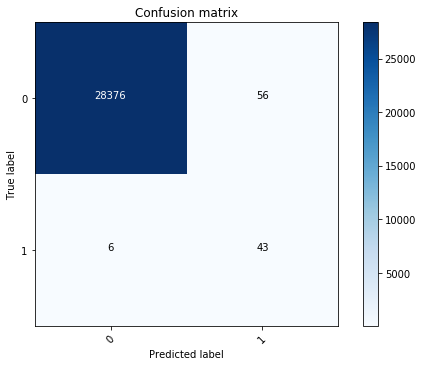

In [52]:
sampling2=SMOTE(ratio=0.1, random_state=2, k=None, k_neighbors=5, 
      m=None, m_neighbors=10, out_step=0.5, kind='regular', svm_estimator=None, n_jobs=2)

X_smt, y_smt=sampling2.fit_sample(df_train[predictors],df_train[response])
X_smt=pd.DataFrame(X_smt)
columns=df_train[predictors].columns
X_smt.columns=columns

#Fit the algorithm on the data
alg = LogisticRegression(penalty = 'l1', C=0.06,random_state = 2)
alg.fit(X_smt[predictors], y_smt)

#Predict test set:
dtest_pred = alg.predict(df_test[predictors])
dtest_predprob = alg.predict_proba(df_test[predictors])[:,1]


prf_test=precision_recall_fscore_support(df_test[response], dtest_pred,pos_label =1, average ='binary')
area_prc_test=average_precision_score(df_test[response], dtest_predprob,average=None)

# Compute confusion matrix
cnf_matrix = confusion_matrix(df_test[response],dtest_pred)
#np.set_printoptions(precision=2)

print "Test Recall: ",round((prf_test[1]*100),2)
print "Test Precision: ",round((prf_test[0]*100),2)
print

# Plot non-normalized confusion matrix
class_names = [0,1]
plt.figure(figsize=(7,5))
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()

We acheived a recall value of 87.76% and a precision of 43.43% on the test set. This is a very decent prediction power on a unbalanced data set using Logistic Regression. Using tree based algorithms like Random Forestes and Xgboost on the data set could further improve the predictions as those algorithms can model complex interactions between the features but that comes at the cost of loss of interpretability. 